# Домашнее задание №2 - Линейные модели. Градиентный спуск

В этом домашнем задании мы с вами научимся обучать линейные модели регрессии и классификации при помощи очень мощного, но в то же время довольно понятного алгоритма, который называется **градиетный спуск**. Помимо линейных моделей он используется и для обучения самых сложных нейронных сетей! Также мы потренируемся применять готовые реализации линейных моделей для задач регрессии и бинарной классификации.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import pandas as pd

from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
from sklearn.exceptions import NotFittedError
from sklearn.linear_model import (LinearRegression,
                                  LogisticRegression)
from sklearn.datasets import load_boston
from sklearn.preprocessing import (StandardScaler, MinMaxScaler)
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from sklearn.metrics import (r2_score,
                             mean_squared_error)
from sklearn.model_selection import train_test_split

<font color="#4B0082">Привет ^^</font>

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

#### Маленькое теоретическое отступление

Основное свойство антиградиента (-1 * градиент) &ndash; он указывает в сторону наискорейшего убывания функции в данной точке. Соответственно, будет логично стартовать из некоторой точки, сдвинуться в сторону антиградиента, пересчитать антиградиент и снова сдвинуться в его сторону и т.д. Запишем это более формально.

Пусть $w_0$ &ndash; начальный набор параметров (коэффициентов линейной модели) ((например, нулевой или сгенерированный из некоторого, случайного распределения)). Тогда обычный градиентный спуск состоит в повторении следующих шагов до сходимости:


$$
    w_{k + 1} = w_{k} - \eta \nabla_{w} Q(w_{k}),
$$

где $\nabla_{w} Q(w_{k})$ &ndash; градиент функции потерь в точке $w_k$, а $\eta$ &ndash; скорость обучения (learning rate).

Градиентный спуск обычно останавливают, когда прошло заданное максимальное количество итераций или когда графиент близок к нулю (т.е. наши параметры практически не меняются). Для реализации второго варианта считают норму градиента (по сути длину вектора). Это можно сделать несколькими способами:

$$
l1_{norm} = \sum{|w_i|}
$$

$$
l2_{norm} = \sum{(w_i)^{2}}
$$

Попробуем разобраться на простом примере. Рассмотрим функцию от двух переменных:
$f(x, y) = \sin^2 x + \sin^2 y$

In [3]:
def f(w):
    """
    :param w: np.array(np.float) вектор из 2-х элементов
    :return: np.float
    """
    
    return np.sum(np.sin(w)**2)

Обратите внимание, что $x$ - numpy-array вектор длины 2.

***Reminder:***  
Что мы хотим? Мы хотим найти минимум этой функции (в машинном обучении мы обычно хотим найти минимум **функции потерь**, например, MSE), а точнее найти $w_1$ и $w_2$ такие, что при них значение $f(w_1, w_2)$ минимально, то есть *точку экстремума*.  
  
Как мы будем искать эту точку? Используем методы оптимизации (в нашем случае - *минимизации*). Одним из таких методов и является **градиентный спуск**.

### Задание 1. Градиентный спуск для функции $f$ (1 балл)

Реализуйте функцию, которая будет осуществлять градиентный спуск для функции $f$:

*Примечание:* Вам нужно посчитать частные производные именно **аналитически** и **переписать их в код**, а не считать производные численно (через отношение приращения функции к приращению аргумента) -- в этих двух случаях могут различаться ответы, поэтому будьте внимательны.

Analytic solution of the derivative:
Total differential of the derivative:
$$
\begin{gather}
dF(x, y) = \frac{\delta F}{\delta x}\cdot dx + \frac{\delta F}{\delta x}\cdot dx = \\
= \frac{\delta (sin(x)^2 + sin(y)^2)}{\delta x}\cdot dx + \frac{\delta (sin(x)^2 + sin(y)^2)}{\delta x}\cdot dx = \\
= 2 \cdot cos(x) + 2 \cdot cos(y)
\end{gather}
$$
Here, the chain rule was used.

In [4]:
def grad_f(w): 
    """
    Градиент функциии f, определенной выше.
        :param w: np.array[2]: float вектор из 2-х элементов
        :return: np.array[2]: float вектор из 2-х элементов
    """
#     return 2*np.sin(w)*np.cos(w)
    return np.sin(2*w)

Проверим, что градиент принимает вектор из двух чисел и выдает на этой точке верное значение

In [5]:
assert np.allclose(grad_f(np.array([1, 2])), 
                   np.array([0.90929743, -0.7568025])), "Что-то не так!"

In [6]:
def grad_descent_2d(f, grad_f, lr, num_iter=100, x0=None):
    """
    Функция, которая реализует градиентный спуск в минимум для функции f от двух переменных. 
        :param f: скалярная функция двух переменных
        :param grad_f: функция, возвращающая градиент функции f (устроена как реализованная вами выше grad_f)
        :param lr: learning rate алгоритма
        :param num_iter: количество итераций градиентного спуска
        :return: np.array[num_iter, 2] пар вида (x, f(x))
    """
    
    w0 = np.random.random(2)

    # будем сохранять значения аргументов и значений функции 
    # в процессе град. спуска в переменную history
    history = []

    # итерация цикла == шаг градиентнго спуска
    curr_w = w0.copy()
    for iter_num in range(num_iter):
        entry = np.hstack((curr_w, f(curr_w)))
        history.append(entry)
        curr_w -= lr*grad_f(curr_w) #  YOUR CODE. Не забудьте про lr!

    return np.vstack(history)

In [7]:
grad_descent_2d(f, grad_f, 0.1, num_iter=10) # ну и зачем это тут....

array([[0.61217018, 0.16906975, 0.35853001],
       [0.51811197, 0.1358965 , 0.26361789],
       [0.43206331, 0.1090506 , 0.18719267],
       [0.35601047, 0.08741298, 0.12910008],
       [0.29067396, 0.0700193 , 0.0870331 ],
       [0.23575887, 0.05606117, 0.05769961],
       [0.19033498, 0.04487241, 0.03780422],
       [0.15318072, 0.03590997, 0.02457035],
       [0.12302157, 0.02873415, 0.01588354],
       [0.09866475, 0.02299048, 0.01023166]])

Визуализируем точки градиентного спуска на 3D-графике нашей функции. Звездочками будут обозначены точки (тройки $w_1, w_2, f(w_1, w_2)$), по которым Ваш алгоритм градиентного спуска двигался к минимуму (Для того, чтобы написовать этот график, мы и сохраняли значения $cur\_w_1, cur\_w_2, f(cur\_w_1, cur\_w_2)$ в `steps` в процессе спуска).

Если у Вас правильно написана функция `grad_descent_2d`, то звездочки на картинке должны сходиться к одной из точек минимума функции. Вы можете менять начальные приближения алгоритма, значения `lr` и `num_iter` и получать разные результаты.

In [8]:
def gradient_desc_vis(f, grad_f, lr=0.1, num_iter=20):
    steps = grad_descent_2d(f, grad_f, lr=lr, num_iter=num_iter)
    
    X, Y = np.meshgrid(np.linspace(-3, 3, 100), np.linspace(-3, 3, 100))

    fig = plt.figure(figsize=(16, 10))
    ax = fig.gca(projection="3d")

    zs = np.array([f(np.array([x,y]))
                  for x, y in zip(np.ravel(X), np.ravel(Y))])
    Z = zs.reshape(X.shape)


    ax.plot_surface(X, Y, Z, cmap="Pastel1", zorder=2)

    ax.plot(xs=steps[:, 0], ys=steps[:, 1], zs=steps[:, 2],
            marker=".", markersize=20, zorder=3, 
            markerfacecolor="#FF6961", lw=3, c="black")

    ax.set_zlim(0, 5)
    ax.view_init(elev=40, azim=90)
    plt.show()
    
    return steps

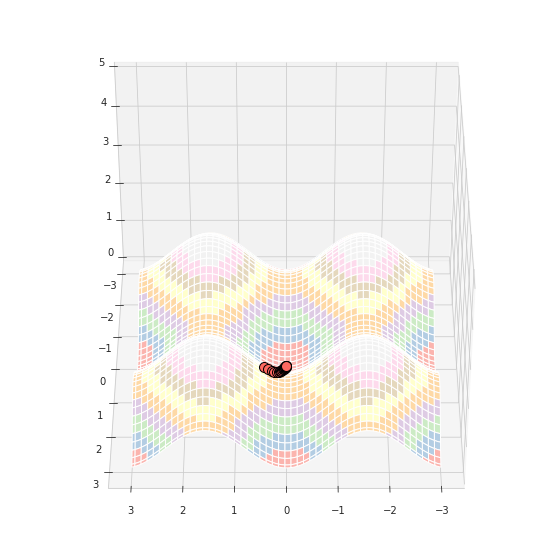

In [9]:
steps = gradient_desc_vis(f, grad_f)

Посмотрим на зависимость значения функции от шага градиентного спуска.

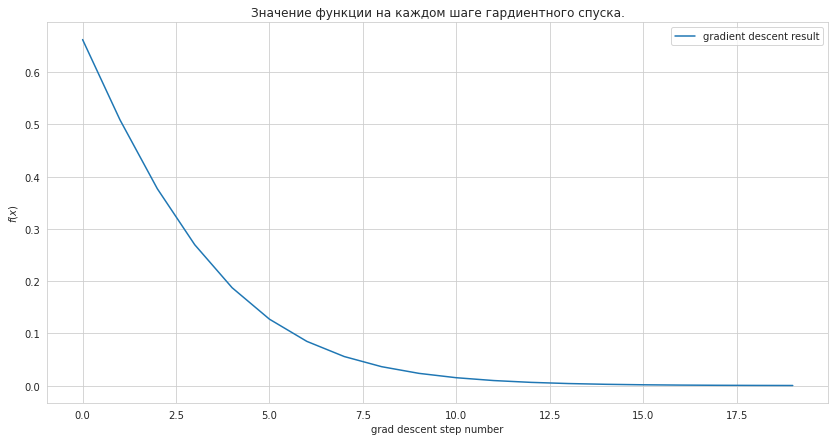

In [10]:
plt.figure(figsize=(14,7))
plt.xlabel("grad descent step number")
plt.ylabel("$f(x)$")
plt.title("Значение функции на каждом шаге гардиентного спуска.")

f_values = list(map(lambda x: x[2], steps))
plt.plot(f_values, label="gradient descent result")
plt.legend();

<font color="#4B0082">(1/1)</font>

### Задание 2. Реализация линейной регресии (суммарно 9 баллов)

Так как мы будем использовать градиентный спуск для обучения модели, важной часть является реализация функции потерь и функции для расчета ее градиента. Перед началом стоит напомнить, как считать градиент MSE. Вывод этой формулы можно найти  [здесь](https://medium.com/analytics-vidhya/linear-regression-gradient-descent-intuition-and-math-c9a8f5aeeb22)

$$
    MSE = \frac{1}{N}\sum(y_{true} - y_{pred}) ^ 2
$$

$$
    \nabla{MSE} = \frac{2}{N} X^T (y_{pred} - y_{true})
$$

Здесь имеется в виду именно матричное умножение.

#### Задание 2.1. MSE и ее градиент (2 балла)

In [11]:
def mse(y_true, y_pred):
    """
    Функция потерь MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :return: mse: int: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
    
    n = y_pred.shape[0]
    mse = 1/n * np.sum(np.square(y_true - y_pred))
    return mse

def mse_grad(y_true, y_pred, X):
    """
    Функция для расчета градиента MSE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: градиент функции потерь MSE
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
    
    n = y_pred.shape[0]
    mse_grad = 2/n * X.T @ (y_pred - y_true)
    return mse_grad

class MSELoss:
    """
    Класс, реализующий функцию потерь MSE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred): # instance can be called like function
        return mse(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return mse_grad(y_true, y_pred, X)

Мы будем использовать следующий класс для расчета градиента наших функций потерь:

In [12]:
class BasicGradientDescent:
    """
    Класс, позволяющий делать шаги градиентного спуска,
    а также рассчитывающих норму градиента.
    """
    
    def __init__(self, loss_function, grad_norm):
        """
        Конструктор нашего класса. 
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param grad_norm: тип нормы градиента l1 или l2
        """
        self.loss = loss_function
        self.grad_norm = grad_norm
        
    
    def step(self, y, y_pred, X):
        grad_i = self.loss.calculate_gradient(y, y_pred, X) # calculate mse_grad
        grad_i_norm = self._calculate_grad_norm(grad_i) # norm mse_gradТ
        
        return grad_i, grad_i_norm
            
            
    def _calculate_grad_norm(self, grad_i):
        if self.grad_norm == "l1": # Calculates the sum of absolute value of vector
            return np.abs(grad_i).sum() 
        elif self.grad_norm == "l2": # Calculates the square of the sum of squared values of vector
            return np.sqrt(np.square(grad_i).sum())
        else:
            raise ValueError(f"I can't calculate {self.grad_norm} norm of gradient")

В данном задании нужно будет реализовать линейную регрессию и обучить ее при помощи градиентного спуска. Для этого нужно будет заполнять пропуски кода в соответствующих классах. Для начала мы реализуем базовый класс для всех линейных моделей, от которого потом будем наследоваться при реализации линейной и логистической регресий. Не переживайте, этот класс уже реализован, вам достостаточно просто разобраться с кодом.

In [13]:
class BaseLinearModel:
    """
    Класс, который представляет из себя базовую линейную модель, наследуюясь от которого, мы будем
    реализовывать линейную и логистическую регрессии.
    """
    
    def __init__(self, learning_rate, 
                 loss_function, fit_intercept,
                 n_iter, tol, optimizer, grad_norm):
        """
        Конструктор нашего класса. 
            :param learning_rate: скорость обучения
            :param loss_function: функция потерь (MSE или кросс-энтропия)
            :param fit_intercept: нужно ли нам включать свободных член в модель
            :param n_iter: количество итераций градиентного спуска
            :param tol: параметр для остановки градиентного спуска,
                        если норма градиента (l1 или l2) меньше tol, то останавливаемся
            :param optimizer: класс, который будет рассчитывать градиент и его норму
            :param grad_norm: тип нормы градиента l1 или l2
        """
        
        self.learning_rate = learning_rate
        self.loss = loss_function
        self.fit_intercept = fit_intercept
        self.n_iter = n_iter
        self.tol = tol
        self.grad_norm = grad_norm
        self.optimizer = optimizer(loss_function, grad_norm)
        
        # В начале параметры модели не заданы
        self.W = None
        
        
    def fit(self, X, y):
        """
        Метод для обучения нашей модели 
            :param X: матрица объекты x признаки
            :param y: вектор значений целевой переменной
            :return: обученная модель
        """
        
        # Сделаем из y вектор-столбец (n_samples, 1)
        y = y.reshape(-1, 1)
        n_samples = X.shape[0]
        
        # Добавим колонку из 1 в матрицу X
        if self.fit_intercept:
            ones_column = np.ones((n_samples, 1))
            X_new = np.hstack((ones_column, X))
        
        n_features = X_new.shape[1]
        
        # Инициализируем веса модели
        if self.W is None:
            self.W = np.random.randn(n_features, 1)
        
        # Обучаем модель градиентным спуском
        for i in range(self.n_iter):
            y_pred = self.predict(X)
            grad_i, grad_i_norm = self.optimizer.step(y, y_pred, X_new)

            # Если градиент близок к 0, останавливаемся
            if grad_i_norm <= self.tol:
                return self
            
            else:
                self.W -= self.learning_rate * grad_i
        
        return self
    
    
    def predict(self, X):
        raise NotImplementedError("It is a basic class for all linear models. You should implement it for descendant class.")
    
    
    def __repr__(self):
        return "Base linear model without prediction skill :("

<font color="#4B0082">(2/2)</font>

#### Задание 2.2. Предсказания линейной регрессии (3 балла)

Реализуйте метод `predict` у класса `CustomLinearRegression`, не забудьте про свободный член!

In [14]:
class CustomLinearRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-2, 
                 loss_function=MSELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        # Если вы не проходили наследование и в частности `super`, то не страшно
        # коротко, с помощью этого мы можем вызывать методы родительского класса
        # в частности здесь мы используем метод `init`
        super().__init__(learning_rate=learning_rate, 
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
        
    
    def predict(self, X_test):
        """
        Метод для вычисления предсказаний 
            :param X_test: np.array[n_test_samples, n_features]: 
                           матрица объекты x признаки (тестовый датасет)
            :return: y_pred: np.array[n_test_samples, 1]: предсказания модели
        """
        
        if self.W is None:
            raise NotFittedError("This CustomLinearRegression instance is not fitted yet, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
            
        y_pred = X_test @ self.W
        return y_pred
    
    
    def __repr__(self):
        return "My custom linear regression"

##### Проверим нашу реализацию на простом примере

In [15]:
X = np.random.randn(100, 1)
y = 2 * X + 5 + 0.5 * np.random.randn(100, 1)

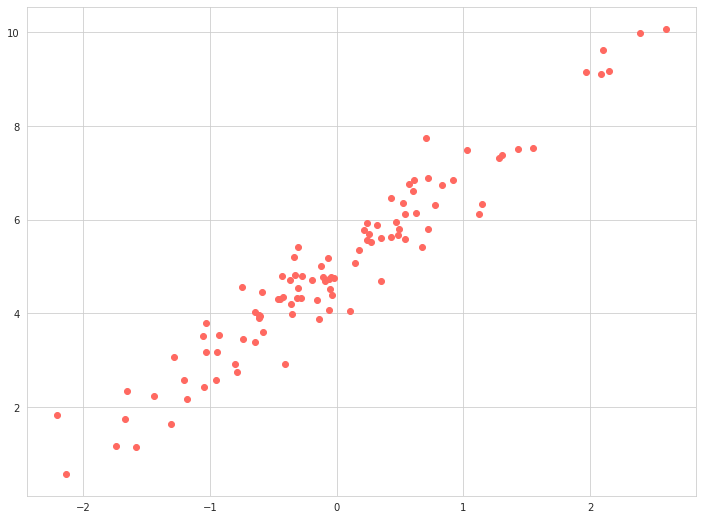

In [16]:
plt.scatter(X, y, c="#FF6961");

In [17]:
custom_lin_reg = CustomLinearRegression()

In [18]:
custom_lin_reg.fit(X, y)

My custom linear regression

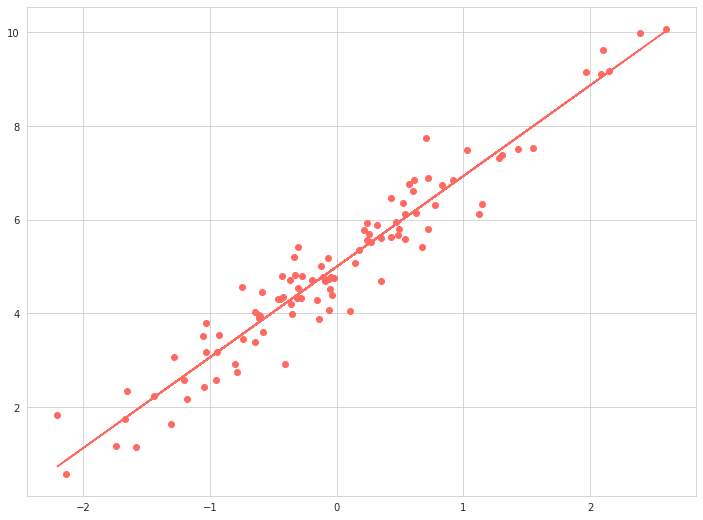

In [19]:
plt.scatter(X, y, c="#FF6961")
plt.plot(X, custom_lin_reg.predict(X), c="#FF6961");

<font color="#4B0082">(3/3)</font>

#### Задание 2.3. Используем встроенную линейную регрессию (4 балла)

Поработаем с данными о ценах на дома в Бостоне. Постройте модель линейной регресии при помощи `LinearRegression` из `sklearn`. Не забудьте разделить данные на тренировочную и тестовую части, а также правильно предобработать признаки. В конце воспользуйтесь какими-то изученными метриками регресии и сделайте выводы о качестве полученной модели, а также о том, какие признаки наиболее важны с точки зрения полученной модели.

In [20]:
data = load_boston()
X, y = data["data"], data["target"]
feature_names = data["feature_names"]

Ваш ход:

##### 1. EDA

In [21]:
X_pd = pd.DataFrame(X, columns=feature_names)
X_pd.describe()

CRIM          ZN       INDUS        CHAS         NOX          RM  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean     3.613524   11.363636   11.136779    0.069170    0.554695    6.284634   
std      8.601545   23.322453    6.860353    0.253994    0.115878    0.702617   
min      0.006320    0.000000    0.460000    0.000000    0.385000    3.561000   
25%      0.082045    0.000000    5.190000    0.000000    0.449000    5.885500   
50%      0.256510    0.000000    9.690000    0.000000    0.538000    6.208500   
75%      3.677083   12.500000   18.100000    0.000000    0.624000    6.623500   
max     88.976200  100.000000   27.740000    1.000000    0.871000    8.780000   

              AGE         DIS         RAD         TAX     PTRATIO           B  \
count  506.000000  506.000000  506.000000  506.000000  506.000000  506.000000   
mean    68.574901    3.795043    9.549407  408.237154   18.455534  356.674032   
std     28.148861    2.105710    8.707259  168.537116    2.164946   91.294864   
min      2.900000    1.129600    1.000000  187.000000   12.600000    0.320000   
25%     45.025000    2.100175    4.000000  279.000000   17.400000  375.377500   
50%     77.500000    3.207450    5.000000  330.000000   19.050000  391.440000   
75%     94.075000    5.188425   24.000000  666.000000   20.200000  396.225000   
max    100.000000   12.126500   24.000000  711.000000   22.000000  396.900000   

            LSTAT  
count  506.000000  
mean    12.653063  
std      7.141062  
min      1.730000  
25%      6.950000  
50%     11.360000  
75%     16.955000  
max     37.970000

In [22]:
X_pd.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    float64
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    float64
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
dtypes: float64(13)
memory usage: 51.5 KB


In [23]:
X_pd[np.abs(X_pd - X_pd.mean()) <= (3 * X_pd.std())]

CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0    0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1    0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2    0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   
3    0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622  3.0  222.0   
4    0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622  3.0  222.0   
..       ...   ...    ...   ...    ...    ...   ...     ...  ...    ...   
501  0.06263   0.0  11.93   0.0  0.573  6.593  69.1  2.4786  1.0  273.0   
502  0.04527   0.0  11.93   0.0  0.573  6.120  76.7  2.2875  1.0  273.0   
503  0.06076   0.0  11.93   0.0  0.573  6.976  91.0  2.1675  1.0  273.0   
504  0.10959   0.0  11.93   0.0  0.573  6.794  89.3  2.3889  1.0  273.0   
505  0.04741   0.0  11.93   0.0  0.573  6.030  80.8  2.5050  1.0  273.0   

     PTRATIO       B  LSTAT  
0       15.3  396.90   4.98  
1       17.8  396.90   9.14  
2       17.8  392.83   4.03  
3       18.7  394.63   2.94  
4       18.7  396.90   5.33  
..       ...     ...    ...  
501     21.0  391.99   9.67  
502     21.0  396.90   9.08  
503     21.0  396.90   5.64  
504     21.0  393.45   6.48  
505     21.0  396.90   7.88  

[506 rows x 13 columns]

There seem to be no big outliers. Obviously, standard scaling is necessary.

In [24]:
print(X_pd.apply(lambda col: col.unique())) # Удобно конечно..

CRIM       [0.00632, 0.02731, 0.02729, 0.03237, 0.06905, ...
ZN         [18.0, 0.0, 12.5, 75.0, 21.0, 90.0, 85.0, 100....
INDUS      [2.31, 7.07, 2.18, 7.87, 8.14, 5.96, 2.95, 6.9...
CHAS                                              [0.0, 1.0]
NOX        [0.538, 0.469, 0.458, 0.524, 0.499, 0.428, 0.4...
RM         [6.575, 6.421, 7.185, 6.998, 7.147, 6.43, 6.01...
AGE        [65.2, 78.9, 61.1, 45.8, 54.2, 58.7, 66.6, 96....
DIS        [4.09, 4.9671, 6.0622, 5.5605, 5.9505, 6.0821,...
RAD           [1.0, 2.0, 3.0, 5.0, 4.0, 8.0, 6.0, 7.0, 24.0]
TAX        [296.0, 242.0, 222.0, 311.0, 307.0, 279.0, 252...
PTRATIO    [15.3, 17.8, 18.7, 15.2, 21.0, 19.2, 18.3, 17....
B          [396.9, 392.83, 394.63, 394.12, 395.6, 386.63,...
LSTAT      [4.98, 9.14, 4.03, 2.94, 5.33, 5.21, 12.43, 19...
dtype: object


In [25]:
X_pd["CHAS"].value_counts()

0.0    471
1.0     35
Name: CHAS, dtype: int64

##### 2. Test-Train split

There seems to be one binary variable CHAS, so I'm going to stratify according to that one (just to be sure, though it doesn't seem to be necessary).

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=X_pd["CHAS"])

##### 3. StandardScaler

In [27]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##### 4. Correlation matrix

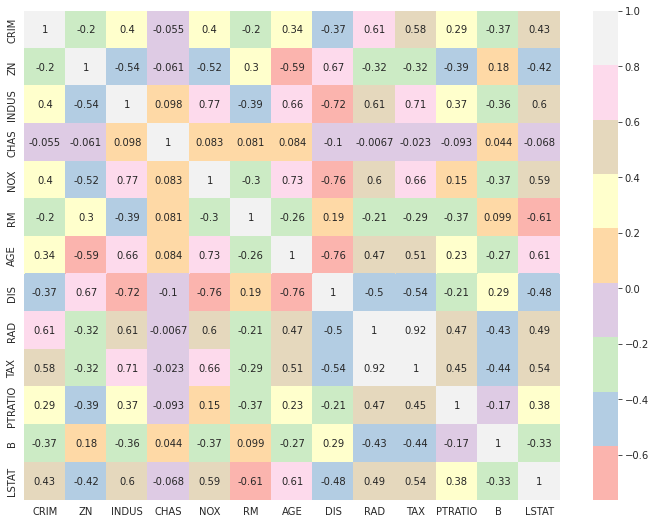

In [28]:
X_train_pd = pd.DataFrame(X_train, columns=feature_names)

# Correlation matrix
corr = X_train_pd.corr()

# Plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
           cmap='Pastel1', annot=True);

There seems to be especially high correlation between variables `TAX` and `RAD`.

Let's also take a look at the correlation with `y`.

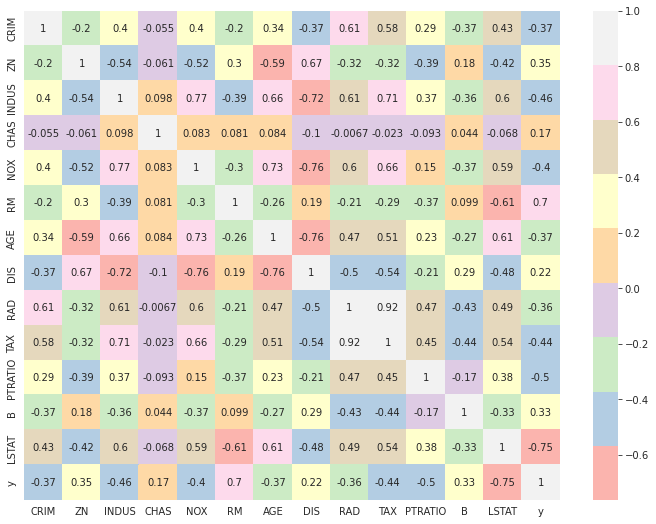

In [29]:
df_train = X_train_pd.assign(y=y_train)


# Correlation matrix
corr = df_train.corr()

# Plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
           cmap='Pastel1', annot=True);

In [30]:
# Take a look at variables with high correlation
cor_var = abs(corr["y"])[abs(corr["y"]) > 0.6]
cor_var

RM       0.698957
LSTAT    0.747310
y        1.000000
Name: y, dtype: float64

Only 2 variables that have correlation higher than 0.6 with `y`. They themselves are however also correlated with each other (-0.61). Now, we don't have many features. That's why I am just going to continue working with all of them. If I had many more features, I might have filtered the lowly correlated ones out already.

<font color="#4B0082">Молодец) Можно еще немного ячейки на хитмапе раздвинуть, но это мне лично просто так нравится</font>

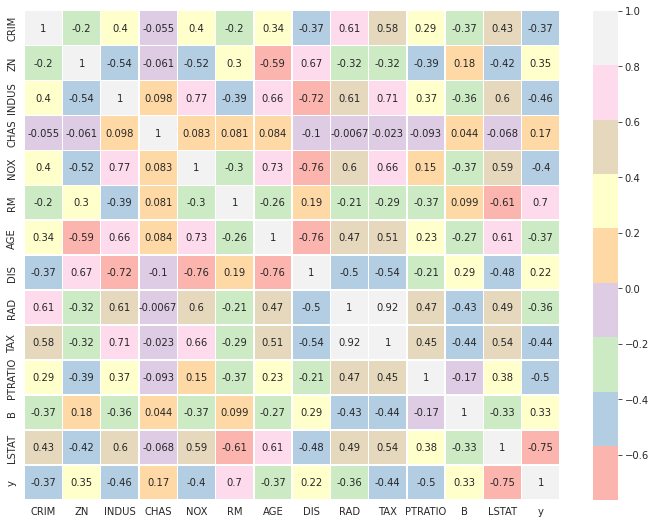

In [31]:
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
           cmap='Pastel1', annot=True, linewidths=0.5);

##### 5. Dependencies

In [32]:
import plotly.express as px


fig = px.scatter_matrix(
    df_train,
    dimensions=feature_names,
    width = 1000,
    height = 1000,
    color=y_train,
    color_continuous_scale=px.colors.sequential.Purpor)
fig.update_traces(diagonal_visible=False)
fig.update_layout(coloraxis_colorbar_title_text = 'Median Price')
fig.show();

<font color="#4B0082">Мелковато, но выглядит красиво</font>

##### 6. Linear Regression

Let's just take all variables first.

<font color="#4B0082">Кстати, ты уже взрослая и пора пользоваться пайплайнами...</font>

In [33]:
regr = LinearRegression()
regr.fit(X_train, y_train)
y_pred = regr.predict(X_test)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.4f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination R2: %.4f" % r2_score(y_test, y_pred))

Coefficients: 
 [-1.02677814  0.98578603  0.16530989  0.71284623 -2.0041352   2.75505431
  0.20142549 -3.09644246  3.24641927 -2.31136455 -2.18465772  1.16536929
 -4.28242652]
Mean squared error: 20.1009
Coefficient of determination R2: 0.5902


## <font color='#FF6961'>Pipeline:</font>

In [34]:
pipe = Pipeline([('scaler', StandardScaler()), ('linear_regression', LinearRegression())])
pipe.fit(X_train, y_train)
y_pred = pipe.predict(X_test)
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.4f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination R2: %.4f" % r2_score(y_test, y_pred))

Coefficients: 
 [-1.02677814  0.98578603  0.16530989  0.71284623 -2.0041352   2.75505431
  0.20142549 -3.09644246  3.24641927 -2.31136455 -2.18465772  1.16536929
 -4.28242652]
Mean squared error: 20.1009
Coefficient of determination R2: 0.5902


##### 7. Other scaling method - MinMax

In [35]:
minmax_scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)
minmax_regr = LinearRegression()
minmax_regr.fit(X_train, y_train)
minmax_y_pred = minmax_regr.predict(X_test)
# The coefficients
print("Coefficients: \n", minmax_regr.coef_)
# The mean squared error
print("Mean squared error: %.4f" % mean_squared_error(y_test, minmax_y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination: %.4f" % r2_score(y_test, minmax_y_pred))

Coefficients: 
 [-1.02677814  0.98578603  0.16530989  0.71284623 -2.0041352   2.75505431
  0.20142549 -3.09644246  3.24641927 -2.31136455 -2.18465772  1.16536929
 -4.28242652]
Mean squared error: 20.1009
Coefficient of determination: 0.5902


Scaling method did not change anything.

## <font color='#FF6961'>Pipeline:</font>

In [36]:
pipe_minmax = Pipeline([('minmax_scaler', MinMaxScaler()), ('linear_regression', LinearRegression())])
pipe_minmax.fit(X_train, y_train)
y_pred = pipe_minmax.predict(X_test)
# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.4f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination R2: %.4f" % r2_score(y_test, y_pred))

Coefficients: 
 [-1.02677814  0.98578603  0.16530989  0.71284623 -2.0041352   2.75505431
  0.20142549 -3.09644246  3.24641927 -2.31136455 -2.18465772  1.16536929
 -4.28242652]
Mean squared error: 20.1009
Coefficient of determination R2: 0.5902


##### 8. Does `stratify` matter?


In [37]:
X_train_wo_str, X_test_wo_str, y_train_wo_str, y_test_wo_str = train_test_split(X, y, test_size=0.2, random_state=SEED)

In [38]:
scaler = StandardScaler()
X_train_wo_str = scaler.fit_transform(X_train_wo_str)
X_test_wo_str = scaler.transform(X_test_wo_str)
regr_wo_str = LinearRegression()
regr_wo_str.fit(X_train_wo_str, y_train_wo_str)
y_pred_wo_str = regr.predict(X_test_wo_str)

# The coefficients
print("Coefficients: \n", regr_wo_str.coef_)
# The mean squared error
print("Mean squared error: %.4f" % mean_squared_error(y_test_wo_str, y_pred_wo_str))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination R2: %.4f" % r2_score(y_test_wo_str, y_pred_wo_str))

Coefficients: 
 [-0.56588761  1.16280848  0.27194895  0.65273153 -1.86285663  2.61881229
 -0.24103612 -2.99781776  2.39924357 -2.03368943 -1.92088152  0.99097724
 -3.70245146]
Mean squared error: 21.9884
Coefficient of determination R2: 0.7576


Without `stratify` R$^2$ increased, however the MSE increased as well. These are two different models and it is not really possible to compare them. I am now just going to continue to work with both of the models.

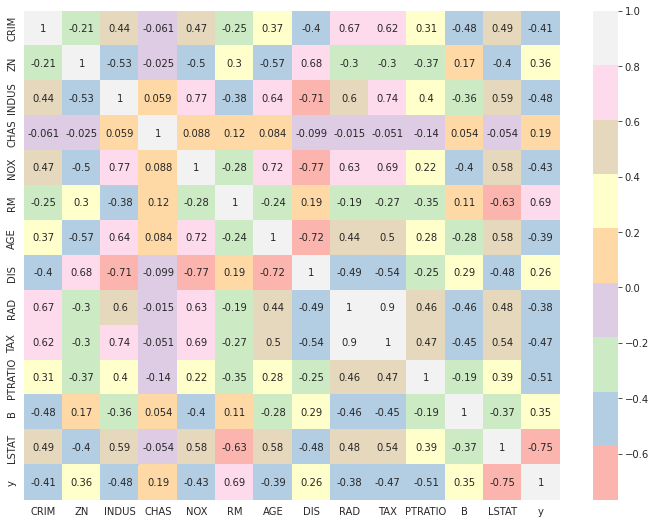

In [39]:
X_train_pd = pd.DataFrame(X_train_wo_str, columns=feature_names)
df_train = X_train_pd.assign(y=y_train_wo_str)


# Correlation matrix
corr = df_train.corr()

# Plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
           cmap='Pastel1', annot=True);

Still looks quite similar.

##### 9. Getting rid of correlated variables and VIF

<font color="#4B0082">Здорово)</font>

In [40]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

def calc_vif(X):

    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return(vif)


calc_vif(X_train_pd)

variables       VIF
0       CRIM  2.127135
1         ZN  2.411476
2      INDUS  4.318872
3       CHAS  1.098090
4        NOX  4.495416
5         RM  2.033375
6        AGE  2.863257
7        DIS  3.979861
8        RAD  7.537708
9        TAX  9.466889
10   PTRATIO  1.736976
11         B  1.448880
12     LSTAT  2.981048

As we saw in correlation matrix above as well as according to VIF, variables `TAX` and `RAD` are highly correlated. Let's get rid of one of them (`TAX`) and see whether that changes the model.

In [41]:
df_train.columns.get_loc("TAX")

9

In [42]:
selector = [col for col in range(X_train.shape[1]) if col != 9]
X_train_wo_TAX = X_train[:, selector]
X_test_wo_TAX = X_test[:, selector]

In [43]:
regr = LinearRegression()
regr.fit(X_train_wo_TAX, y_train)
y_pred = regr.predict(X_test_wo_TAX)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.4f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination R2: %.4f" % r2_score(y_test, y_pred))

Coefficients: 
 [-1.02144401  0.77969955 -0.4323667   0.80105162 -2.12785897  2.84211749
  0.15881622 -3.15198849  1.51671584 -2.20945111  1.19609554 -4.26291116]
Mean squared error: 20.0849
Coefficient of determination R2: 0.5905


Before:
* Mean squared error: 20.1009
* Coefficient of determination: 0.5902

After:
* Mean squared error: 20.0849
* Coefficient of determination R2: 0.5905

It slightly decreased the MSE and increased R$^2$ but didn't really improve the model substantially.


First, try out without `stratify`.

In [44]:
selector = [col for col in range(X_train.shape[1]) if col != 9]
print(selector)
X_train_wo_TAX = X_train_wo_str[:, selector]
X_test_wo_TAX = X_test_wo_str[:, selector]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12]


In [45]:
regr = LinearRegression()
regr.fit(X_train_wo_TAX, y_train_wo_str)
y_pred = regr.predict(X_test_wo_TAX)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.4f" % mean_squared_error(y_test_wo_str, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination R2: %.4f" % r2_score(y_test_wo_str, y_pred))

Coefficients: 
 [-0.5393436   0.86939072 -0.41339811  0.76512966 -1.9221025   2.67714856
 -0.27339756 -2.94057631  0.99443326 -2.01211357  1.00097966 -3.67960112]
Mean squared error: 23.7120
Coefficient of determination R2: 0.7385


Before:
* Mean squared error: 21.9884
* Coefficient of determination: 0.7576

After:
* Mean squared error: 23.7120
* Coefficient of determination R2: 0.7385

It slightly inreased the MSE and decreased R$^2$ so it kind of made the model worse.

What if we now try out `RAD`?

In [46]:
df_train.columns.get_loc("RAD")

8

In [47]:
selector = [col for col in range(X_train.shape[1]) if col != 8]
X_train_wo_RAD = X_train[:, selector]
X_test_wo_RAD = X_test[:, selector]

In [48]:
regr = LinearRegression()
regr.fit(X_train_wo_RAD, y_train)
y_pred = regr.predict(X_test_wo_RAD)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.4f" % mean_squared_error(y_test, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination R2: %.4f" % r2_score(y_test, y_pred))

Coefficients: 
 [-0.65521665  0.90154063 -0.39739855  0.82188626 -1.68177389  3.01965444
  0.08326936 -3.19404329  0.46821518 -1.800191    1.09008177 -4.22055808]
Mean squared error: 19.5194
Coefficient of determination R2: 0.6021


Before:
* Mean squared error: 20.1009
* Coefficient of determination: 0.5902

After:
* Mean squared error: 19.5194
* Coefficient of determination R2: 0.6021

It decreased the MSE and increased R$^2$, the improvement is more prominent than with `TAX`. 

In [49]:
selector = [col for col in range(X_train.shape[1]) if col != 8]
X_train_wo_RAD = X_train_wo_str[:, selector]
X_test_wo_RAD = X_test_wo_str[:, selector]

In [50]:
regr = LinearRegression()
regr.fit(X_train_wo_RAD, y_train_wo_str)
y_pred = regr.predict(X_test_wo_RAD)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.4f" % mean_squared_error(y_test_wo_str, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination R2: %.4f" % r2_score(y_test_wo_str, y_pred))

Coefficients: 
 [-0.16946469  0.92466088 -0.29596604  0.77467356 -1.52291328  2.83525408
 -0.37251675 -2.89245076  0.0478056  -1.73580779  0.94474365 -3.63214068]
Mean squared error: 24.9679
Coefficient of determination R2: 0.7247


Before:
* Mean squared error: 21.9884
* Coefficient of determination: 0.7576

After:
* Mean squared error: 24.9679
* Coefficient of determination R2: 0.7247

It slightly inreased the MSE and decreased R$^2$ so it kind of made the model worse.

**WE HAVE CONFLICTING RESULTS WITH AND WITHOUT USING `stratify`.** I assume deleting the variables doesn't matter as much.

Let's check VIF:

In [51]:
calc_vif(pd.DataFrame(X_train_wo_RAD))

variables       VIF
0           0  1.921353
1           1  2.337211
2           2  3.896537
3           3  1.078618
4           4  4.344093
5           5  1.972031
6           6  2.840621
7           7  3.965323
8           8  3.793515
9           9  1.692124
10         10  1.446081
11         11  2.974574

At least VIF got better though.

<font color="#4B0082">Модель может и стала похуже, зато если бы надо было как-то причинно-следственные связи устанавливать, то так было бы проще</font>

##### 10. Getting rid of the variables that do not correlate that much.

In [52]:
# Take a look at variables with low correlation
cor_var = abs(corr["y"])[abs(corr["y"]) < 0.3]
cor_var

CHAS    0.186697
DIS     0.258588
Name: y, dtype: float64

Taking the model without `stratify`

In [53]:
df_train.columns.get_loc("CHAS")

3

In [54]:
selector = [col for col in range(X_train.shape[1]) if col != 3]
X_train_wo_CHAS = X_train_wo_str[:, selector]
X_test_wo_CHAS = X_test_wo_str[:, selector]

In [55]:
regr = LinearRegression()
regr.fit(X_train_wo_CHAS, y_train_wo_str)
y_pred = regr.predict(X_test_wo_CHAS)

# The coefficients
print("Coefficients: \n", regr.coef_)
# The mean squared error
print("Mean squared error: %.4f" % mean_squared_error(y_test_wo_str, y_pred))
# The coefficient of determination: 1 is perfect prediction
print("Coefficient of determination R2: %.4f" % r2_score(y_test_wo_str, y_pred))

Coefficients: 
 [-0.61063219  1.21519709  0.44193177 -1.82091939  2.67085613 -0.19146476
 -3.04245481  2.62697086 -2.34470236 -2.00342091  1.03358235 -3.73254589]
Mean squared error: 23.6662
Coefficient of determination R2: 0.7391


Before:
* Mean squared error: 21.9884
* Coefficient of determination: 0.7576

After:
* Mean squared error: 23.6662
* Coefficient of determination R2: 0.7391

It slightly inreased the MSE and decreased R$^2$ so it kind of again made the model worse.

<font color="#4B0082">(5.5/4)</font>

### Задание 3. Реализация логистической регресии (суммарно 10 баллов)

Логистическая регрессия не очень сильно отличается от обычной линейной регрессии и используется в задах классификации. Так как здесь мы снова будем пользоваться градиентным спуском, то нужно определить функцию потерь и ее градиент. Одним из самых популярных вариантов в задаче бинарной классификации является бинарная кросс-энтропия (BCE).

$$\mathcal L_{BCE}(y, \hat y) = -\frac{1}{N} \sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Единственная проблема данной функции это возможность получить 0 под знаком логарифма, что не очень хорошо. Попробуем справить с этим "в лоб". Скажем, что наши предсказания могут принимать значения от 0 + eps до 1 - eps, где eps очень маленькое число.

#### Задание 3.1. Реализация сигмоиды (0.5 баллов)

Реализуйте функцию `sigmoid`, которая переводит действительное число $\mathbb R$ в вероятность $[0,1]$.

In [56]:
def sigmoid(output):
    # output результат X@w (-inf, +inf)
    return 1/(1 + np.exp(-output))

#### Задание 3.2. BCE Loss и ее градиент (2.5 балла)

Так как мы с вами только начинаем изучать машинное обучение, то было бы слишком жестоко просить вас вычислить градиент BCE Loss (он не так сложен, просто нужно привыкнуть). Поэтому сразу напишем формулу для него:

BCE Loss

$$
\nabla{\mathcal L_{BCE}(y, \hat y), X} = X^T (\sigma({\hat{y}}) - y)
$$


In [57]:
def bce(y_true, y_pred, eps=1e-15):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    n = y_true.shape[0]
    
    # I want to avoid log(0)
    y_pred = np.clip(y_pred, eps, 1 - eps)
    
    bce = - 1/n * np.sum(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return bce

def bce_grad(y_true, y_pred, X):
    """
    Функция потерь BCE.
        :param y_true: np.array[n_samples]: вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :param X: np.array[n_samples, n_features]: матрица объекты x признаки
        :return: значение функции потерь
    """
    
    if  y_true.shape[0] != y_pred.shape[0]:
        raise ValueError("Number of samples in both vectors should be equal")
        
    bce_grad = X.T @ (y_pred - y_true)
    return bce_grad


class BCELoss:
    """
    Класс, реализующий функцию потерь BCE. Нужен для того, чтобы
    объединять в одном месте функцию потерь и градиент для нее.
    """
    
    def __call__(self, y_true, y_pred):
        return bce(y_true, y_pred)
    
    def calculate_gradient(self, y_true, y_pred, X):
        return bce_grad(y_true, y_pred, X)

<font color="#4B0082">График ниже у тебя выглядит не странно, но смотри, ты в лоссе берешь сигмоиду от предсказаний, а сами предсказания возвращаются как сигмоида от логитов, то есть выходит два раза берется сигмоида. Если я что-то не заметил и ты где-то это обрабатываешь отдельно, то скажи)</font>

<font color="#4B0082">(2.5/2.5)</font>

#### Задание 3.3. Предсказания логистической регрессии (2 балла)

Реализуйте метод `predict` у класса `CustomLogisticRegression`, не забудьте про свободный член!

## <font color='#FF6961'>Correcting Sigmoid:</font>

In [58]:
class CustomLogisticRegression(BaseLinearModel):
    def __init__(self, learning_rate: float = 1e-3,
                 loss_function=BCELoss(), fit_intercept=True,
                 n_iter=1000, tol=1e-5, optimizer=BasicGradientDescent, grad_norm="l1"):
        
        super().__init__(learning_rate=learning_rate,
                         loss_function=loss_function, fit_intercept=fit_intercept,
                         n_iter=n_iter, tol=tol, optimizer=optimizer, grad_norm=grad_norm)
    
    
    def predict(self, X_test):
        if self.W is None:
            raise NotFittedError("This CustomLogisticRegression instance is not fitted, run fit method.")
        
        n_test_samples = X_test.shape[0]
        if self.fit_intercept:
            ones_column = np.ones((n_test_samples, 1))
            X_test = np.hstack((ones_column, X_test))
        
        y_pred = sigmoid(X_test @ self.W)
        return y_pred
    
    
    def __repr__(self):
        return "My custom logistic regression"

#### Снова проверим работу алгоритма на простом примере

In [107]:
# Создадим датасет из 1 признака и 2 классов
X, y = make_classification(n_features=1, n_informative=1,
                           n_redundant=0, n_clusters_per_class=1,
                          random_state=SEED
                          )

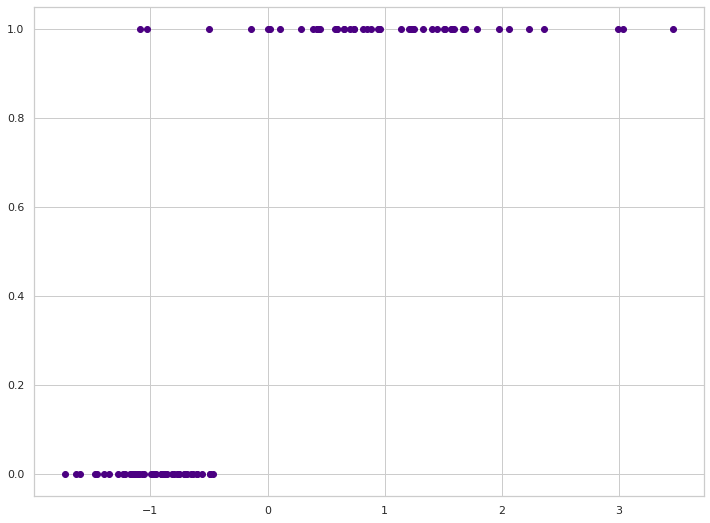

In [108]:
plt.scatter(X, y, c="#4B0082");

In [109]:
custom_log_reg = CustomLogisticRegression()
custom_log_reg.fit(X, y)
y_pred = custom_log_reg.predict(X)

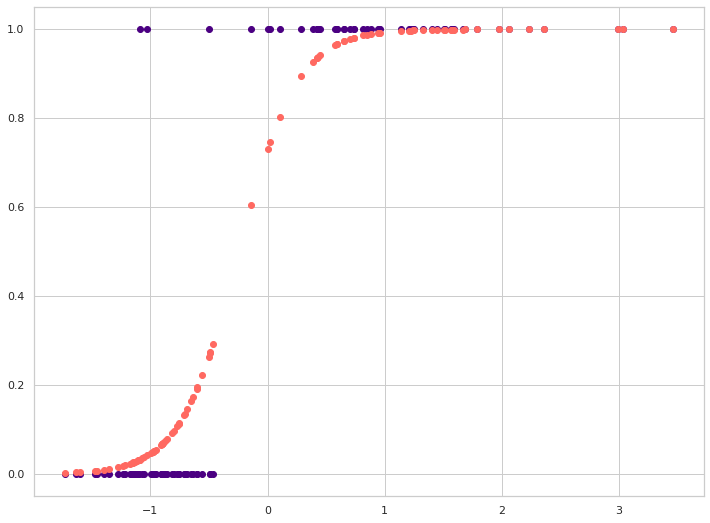

In [110]:
plt.scatter(X, y, c="#4B0082")
plt.scatter(X, y_pred, c="#FF6961");

Проверьте качество работы модели при помощи известных вам метрик бинарной классификации.

In [63]:
y_pred = np.where(y_pred < 0.5, 0, 1)

Checking quality:

In [64]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
print(f"Precision: {precision_score(y, y_pred)}")
print(f"Recall: {recall_score(y, y_pred)}")
print(f"Accuracy: {accuracy_score(y, y_pred)}")
print(f"F1: {f1_score(y, y_pred)}")

Precision: 1.0
Recall: 0.94
Accuracy: 0.97
F1: 0.9690721649484536


Predictions seem to be quite good!

<font color="#4B0082">(0/2)</font>

#### Задание 3.4. Применение логистической регрессии (5 баллов)

Мы будем использовать данные по свойствам покемонов (https://www.kaggle.com/abcsds/pokemon). В данном задании вам необходимо сначала сделать краткий EDA (Посмотреть на данные и их распределения, а также посмотреть, как различные признаки связаны между собой и с целевой переменной (`Legendary`)).

##### 1. Reading the file

In [65]:
pokemon = pd.read_csv("../data_folder/Pokemon.csv", index_col=0)
pokemon.head()

Name Type 1  Type 2  Total  HP  Attack  Defense  Sp. Atk  \
#                                                                              
1              Bulbasaur  Grass  Poison    318  45      49       49       65   
2                Ivysaur  Grass  Poison    405  60      62       63       80   
3               Venusaur  Grass  Poison    525  80      82       83      100   
3  VenusaurMega Venusaur  Grass  Poison    625  80     100      123      122   
4             Charmander   Fire     NaN    309  39      52       43       60   

   Sp. Def  Speed  Generation  Legendary  
#                                         
1       65     45           1      False  
2       80     60           1      False  
3      100     80           1      False  
3      120     80           1      False  
4       50     65           1      False

##### 2. Taking a look at the basic info, description and unique values

In [66]:
pokemon.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 800 entries, 1 to 721
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Name        800 non-null    object
 1   Type 1      800 non-null    object
 2   Type 2      414 non-null    object
 3   Total       800 non-null    int64 
 4   HP          800 non-null    int64 
 5   Attack      800 non-null    int64 
 6   Defense     800 non-null    int64 
 7   Sp. Atk     800 non-null    int64 
 8   Sp. Def     800 non-null    int64 
 9   Speed       800 non-null    int64 
 10  Generation  800 non-null    int64 
 11  Legendary   800 non-null    bool  
dtypes: bool(1), int64(8), object(3)
memory usage: 75.8+ KB


In [67]:
pokemon.describe()

Total          HP      Attack     Defense     Sp. Atk     Sp. Def  \
count  800.00000  800.000000  800.000000  800.000000  800.000000  800.000000   
mean   435.10250   69.258750   79.001250   73.842500   72.820000   71.902500   
std    119.96304   25.534669   32.457366   31.183501   32.722294   27.828916   
min    180.00000    1.000000    5.000000    5.000000   10.000000   20.000000   
25%    330.00000   50.000000   55.000000   50.000000   49.750000   50.000000   
50%    450.00000   65.000000   75.000000   70.000000   65.000000   70.000000   
75%    515.00000   80.000000  100.000000   90.000000   95.000000   90.000000   
max    780.00000  255.000000  190.000000  230.000000  194.000000  230.000000   

            Speed  Generation  
count  800.000000   800.00000  
mean    68.277500     3.32375  
std     29.060474     1.66129  
min      5.000000     1.00000  
25%     45.000000     2.00000  
50%     65.000000     3.00000  
75%     90.000000     5.00000  
max    180.000000     6.00000

In [68]:
print(pokemon.apply(lambda col: col.unique()))

Name          [Bulbasaur, Ivysaur, Venusaur, VenusaurMega Ve...
Type 1        [Grass, Fire, Water, Bug, Normal, Poison, Elec...
Type 2        [Poison, nan, Flying, Dragon, Ground, Fairy, G...
Total         [318, 405, 525, 625, 309, 534, 634, 314, 530, ...
HP            [45, 60, 80, 39, 58, 78, 44, 59, 79, 50, 40, 6...
Attack        [49, 62, 82, 100, 52, 64, 84, 130, 104, 48, 63...
Defense       [49, 63, 83, 123, 43, 58, 78, 111, 65, 80, 100...
Sp. Atk       [65, 80, 100, 122, 60, 109, 130, 159, 50, 85, ...
Sp. Def       [65, 80, 100, 120, 50, 85, 115, 64, 105, 20, 2...
Speed         [45, 60, 80, 65, 100, 43, 58, 78, 30, 70, 50, ...
Generation                                   [1, 2, 3, 4, 5, 6]
Legendary                                         [False, True]
dtype: object


We have 3 columns with `str` and 1 column with `bool`, which is also out target.

Number of NAs in each column:

In [69]:
pokemon.isna().sum()

Name            0
Type 1          0
Type 2        386
Total           0
HP              0
Attack          0
Defense         0
Sp. Atk         0
Sp. Def         0
Speed           0
Generation      0
Legendary       0
dtype: int64

##### 3. Taking a look at collinearity between the variables

In [70]:
num_pokemon = pokemon.select_dtypes(include=[np.number])
num_pokemon.columns

Index(['Total', 'HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def', 'Speed',
       'Generation'],
      dtype='object')

In [71]:
num_pokemon[np.abs(num_pokemon - num_pokemon.mean()) <= (3 * num_pokemon.std())]

Total    HP  Attack  Defense  Sp. Atk  Sp. Def  Speed  Generation
#                                                                     
1      318  45.0    49.0     49.0     65.0     65.0   45.0           1
2      405  60.0    62.0     63.0     80.0     80.0   60.0           1
3      525  80.0    82.0     83.0    100.0    100.0   80.0           1
3      625  80.0   100.0    123.0    122.0    120.0   80.0           1
4      309  39.0    52.0     43.0     60.0     50.0   65.0           1
..     ...   ...     ...      ...      ...      ...    ...         ...
719    600  50.0   100.0    150.0    100.0    150.0   50.0           6
719    700  50.0   160.0    110.0    160.0    110.0  110.0           6
720    600  80.0   110.0     60.0    150.0    130.0   70.0           6
720    680  80.0   160.0     60.0    170.0    130.0   80.0           6
721    600  80.0   110.0    120.0    130.0     90.0   70.0           6

[800 rows x 8 columns]

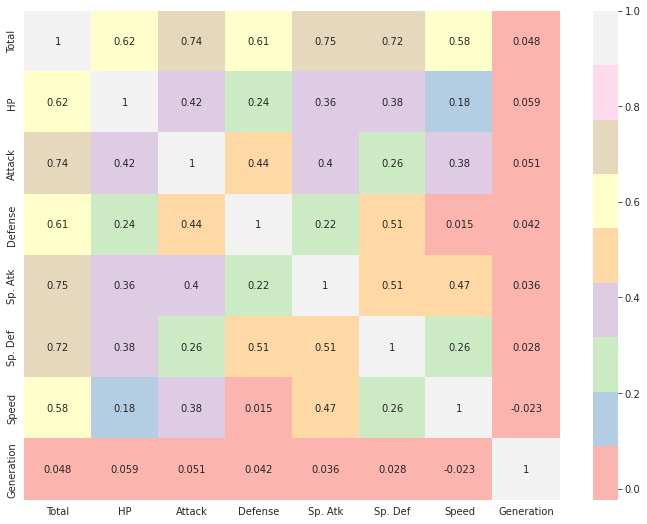

In [72]:
# Correlation matrix
corr = num_pokemon.corr()

# Plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
           cmap='Pastel1', annot=True);

There doesn't seem to be high correlation between the variables.

In [73]:
fig = px.scatter_matrix(
    num_pokemon,
    dimensions=num_pokemon.columns,
    width = 1500,
    height = 1500,
    color=pokemon['Legendary'])
fig.update_traces(diagonal_visible=False)
fig.update_layout(coloraxis_colorbar_title_text = 'Median Price')
fig.show();

There seem to be no big outliers. Obviously, standard scaling is necessary.

In [74]:
for c in pokemon.columns:
    print("------- %s -------" % c)
    print(pokemon[c].value_counts())

------- Name -------
Bulbasaur              1
Uxie                   1
GalladeMega Gallade    1
Probopass              1
Dusknoir               1
                      ..
Lugia                  1
Ho-oh                  1
Celebi                 1
Treecko                1
Volcanion              1
Name: Name, Length: 800, dtype: int64
------- Type 1 -------
Water       112
Normal       98
Grass        70
Bug          69
Psychic      57
Fire         52
Electric     44
Rock         44
Dragon       32
Ground       32
Ghost        32
Dark         31
Poison       28
Steel        27
Fighting     27
Ice          24
Fairy        17
Flying        4
Name: Type 1, dtype: int64
------- Type 2 -------
Flying      97
Ground      35
Poison      34
Psychic     33
Fighting    26
Grass       25
Fairy       23
Steel       22
Dark        20
Dragon      18
Water       14
Ghost       14
Ice         14
Rock        14
Fire        12
Electric     6
Normal       4
Bug          3
Name: Type 2, dtype: int64
------- 

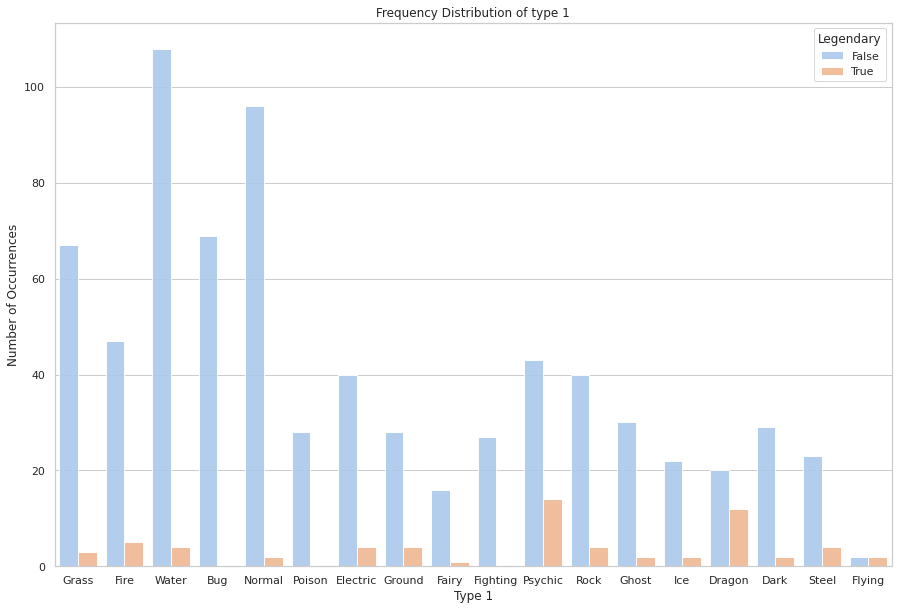

In [75]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 10))
sns.countplot(x="Type 1", data=pokemon, alpha=0.9, palette='pastel',
           hue="Legendary")
plt.title('Frequency Distribution of type 1')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type 1', fontsize=12)
plt.show()

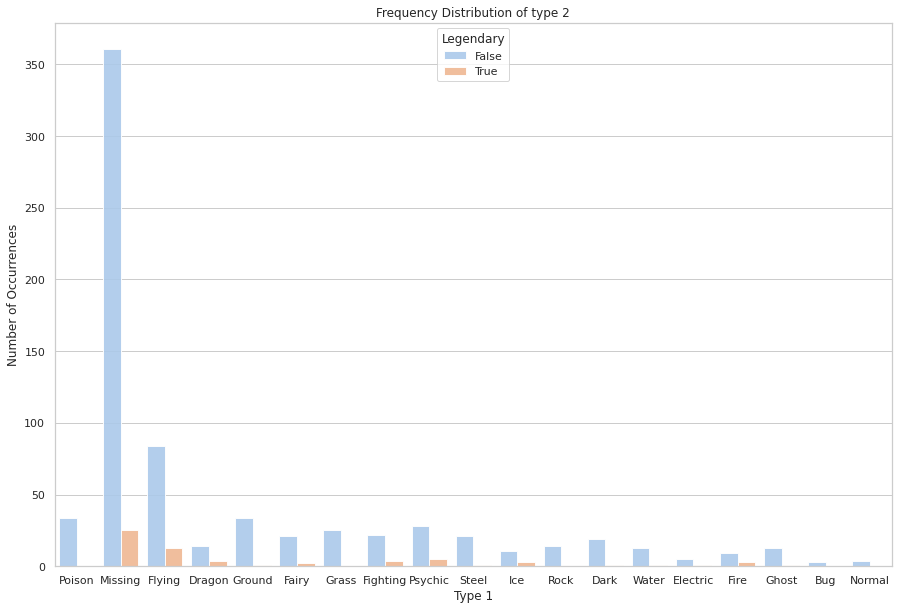

In [76]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(15, 10))
sns.countplot(x="Type 2", data=pokemon.fillna("Missing"), alpha=0.9, palette='pastel',
           hue="Legendary")
plt.title('Frequency Distribution of type 2')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Type 1', fontsize=12)
plt.show()

Мы будем предсказывать является ли покемон легендарным или нет. Замените логическое значение колонки на числовое (перекодировав на 0 и 1). Также подумайте, как в этом случае лучше закодировать категориальные признаки (может быть, лучше их просто выбросить?).

We are not going to use `Names` for prediction, because they are unique for each pokemon. Furthemore, we are not going to use `Type 2` for the prediction because, well, the data is missing for half of the dataset and according to the plot above it doesn't seem to be a promising predictor as some types are very infrequent.

##### 4. First we convert `bool` to 0 and 1.

In [77]:
pokemon["Legendary"] = np.where(pokemon["Legendary"], 1, 0)

##### 5. One-Hot-Encoding `Type 1`

In [78]:
pokemon_enc = pd.get_dummies(pokemon, columns=["Type 1"])
pokemon_enc

Name  Type 2  Total  HP  Attack  Defense  Sp. Atk  \
#                                                                         
1                Bulbasaur  Poison    318  45      49       49       65   
2                  Ivysaur  Poison    405  60      62       63       80   
3                 Venusaur  Poison    525  80      82       83      100   
3    VenusaurMega Venusaur  Poison    625  80     100      123      122   
4               Charmander     NaN    309  39      52       43       60   
..                     ...     ...    ...  ..     ...      ...      ...   
719                Diancie   Fairy    600  50     100      150      100   
719    DiancieMega Diancie   Fairy    700  50     160      110      160   
720    HoopaHoopa Confined   Ghost    600  80     110       60      150   
720     HoopaHoopa Unbound    Dark    680  80     160       60      170   
721              Volcanion   Water    600  80     110      120      130   

     Sp. Def  Speed  Generation  ...  Type 1_Ghost  Type 1_Grass  \
#                                ...                               
1         65     45           1  ...             0             1   
2         80     60           1  ...             0             1   
3        100     80           1  ...             0             1   
3        120     80           1  ...             0             1   
4         50     65           1  ...             0             0   
..       ...    ...         ...  ...           ...           ...   
719      150     50           6  ...             0             0   
719      110    110           6  ...             0             0   
720      130     70           6  ...             0             0   
720      130     80           6  ...             0             0   
721       90     70           6  ...             0             0   

     Type 1_Ground  Type 1_Ice  Type 1_Normal  Type 1_Poison  Type 1_Psychic  \
#                                                                              
1                0           0              0              0               0   
2                0           0              0              0               0   
3                0           0              0              0               0   
3                0           0              0              0               0   
4                0           0              0              0               0   
..             ...         ...            ...            ...             ...   
719              0           0              0              0               0   
719              0           0              0              0               0   
720              0           0              0              0               1   
720              0           0              0              0               1   
721              0           0              0              0               0   

     Type 1_Rock  Type 1_Steel  Type 1_Water  
#                                             
1              0             0             0  
2              0             0             0  
3              0             0             0  
3              0             0             0  
4              0             0             0  
..           ...           ...           ...  
719            1             0             0  
719            1             0             0  
720            0             0             0  
720            0             0             0  
721            0             0             0  

[800 rows x 29 columns]

##### 6. Train-test-split

In [79]:
X = pokemon_enc.drop(columns=['Name', 'Type 2', 'Legendary'])
y = pokemon_enc['Legendary'].values

In [80]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

##### 7. `StandardScaler`

In [81]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##### 8. `LogisticRegression` from `sklearn`

In [82]:
logisticRegr = LogisticRegression()
logisticRegr.fit(X_train, y_train)
y_pred = logisticRegr.predict(X_test)

Выведите метрики вашего классификатора:

1. Нарисуйте [confusion matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.plot_confusion_matrix.html).

2. Изобразите ROC кривую и посчитайте площадь под ней.

3. Скажите, какие признаки оказались наиболее важны для модели.

##### 9. Metrics

For train:

In [83]:
y_pred = logisticRegr.predict(X_train)
print(f"Precision: {precision_score(y_train, y_pred)}")
print(f"Recall: {recall_score(y_train, y_pred)}")
print(f"Accuracy: {accuracy_score(y_train, y_pred)}")
print(f"F1: {f1_score(y_train, y_pred)}")

Precision: 0.8085106382978723
Recall: 0.7307692307692307
Accuracy: 0.9640625
F1: 0.7676767676767676


For test:

In [84]:
y_pred = logisticRegr.predict(X_test)
print(f"Precision: {precision_score(y_test, y_pred)}")
print(f"Recall: {recall_score(y_test, y_pred)}")
print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
print(f"F1: {f1_score(y_test, y_pred)}")

Precision: 0.5555555555555556
Recall: 0.38461538461538464
Accuracy: 0.925
F1: 0.4545454545454546


##### 10. Confusion matrix

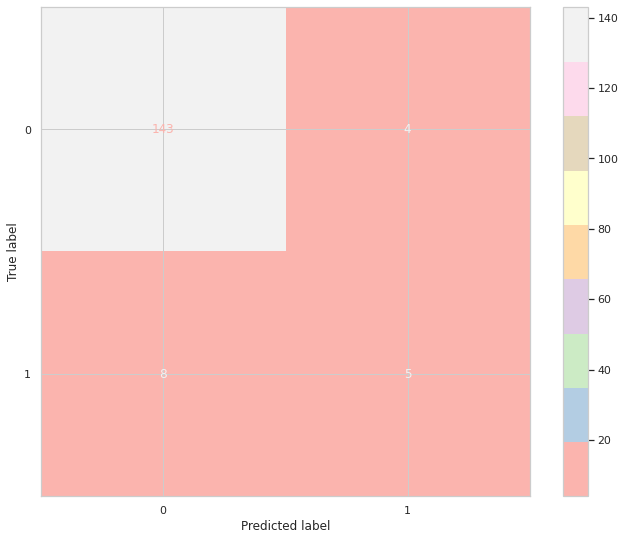

In [85]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(logisticRegr, X_test, y_test,
                     cmap="Pastel1");

Overall high accuracy, but very high false positive and false negative rate!!!

##### 11. ROC and area under it.

The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve. The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

In [86]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

No Skill: ROC AUC=0.500
Logistic: ROC AUC=0.915


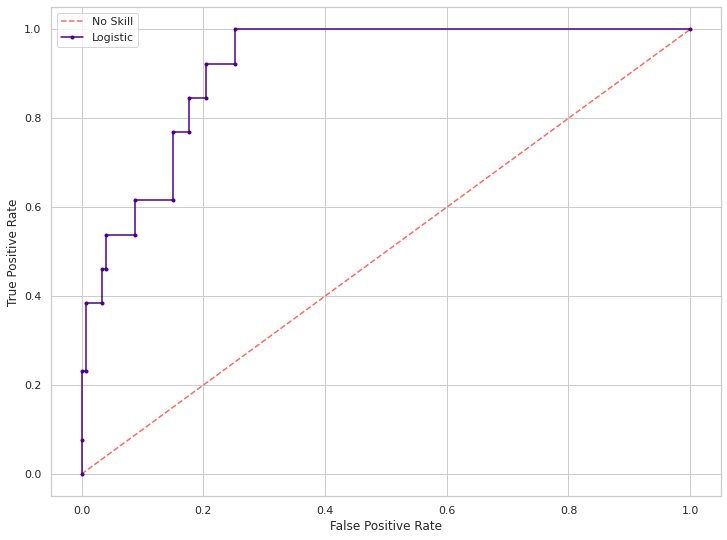

In [87]:
# Make the decision of y
y_score = logisticRegr.decision_function((X_test))
# generate a no skill prediction (majority class) (random)
ns_probs = [0 for _ in range(len(y_test))]
# predict probabilities
lr_probs = logisticRegr.predict_proba(X_test)
# keep probabilities for the positive outcome only
lr_probs = lr_probs[:, 1]
# calculate scores
ns_auc = roc_auc_score(y_test, ns_probs)
lr_auc = roc_auc_score(y_test, y_score)
# summarize scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('Logistic: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves
ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, y_score)
# plot the roc curve for the model
plt.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill', c="#FF6961")
plt.plot(lr_fpr, lr_tpr, marker='.', label='Logistic', c="#4B0082")
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# show the legend
plt.legend()
# show the plot
plt.show()

### 12. Trying to improve the model

Maybe removing `Type 1` could be helpful?

## <font color='#FF6961'>Defining `logistRegr_metrics` function:</font>

Here I define a function for the steps 7-10 for better readibility, therefore the steps won't be explicitly divided as text:

In [88]:
def logistRegr_metrics(X_train, X_test, y_train, y_test, y_pred):
    """
    Функция для построения логистической регрессии с sklearn library и вычисления метрик.
        :param X_true: pandas dataframe[n_samples, n_predictors]: трен. данные
        :param X_test: pandas dataframe[n_samples, n_predictors]: тест. даннные
        :param y_test: np.array[n_samples]: тест. данные, вектор из правильных ответов 0/1
        :param y_true: np.array[n_samples]: трен. данные, вектор из правильных ответов 0/1
        :param y_pred: np.array[n_samples]: вектор из предсказаний модели (вероятности)
        :return: значение функции потерь
    """
    
    # Standardscaler
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Logistic regression from sklearn
    logisticRegr = LogisticRegression()
    logisticRegr.fit(X_train, y_train)
    y_pred = logisticRegr.predict(X_test)

    # Metrics
    # For train
    y_pred = logisticRegr.predict(X_train)
    print(f"Train Precision: {precision_score(y_train, y_pred)}")
    print(f"Train Recall: {recall_score(y_train, y_pred)}")
    print(f"Train Accuracy: {accuracy_score(y_train, y_pred)}")
    print(f"Train F1: {f1_score(y_train, y_pred)}")

    # For test
    y_pred = logisticRegr.predict(X_test)
    print(f"Test Precision: {precision_score(y_test, y_pred)}")
    print(f"Test Recall: {recall_score(y_test, y_pred)}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"Test F1: {f1_score(y_test, y_pred)}")

    # Confusion matrix
    from sklearn.metrics import plot_confusion_matrix
    plot_confusion_matrix(logisticRegr, X_test, y_test,
                         cmap="Pastel1")
    plt.title("Confusion matrix", fontsize=20)
    plt.show()

    # Correlation matrix
    corr = num_pokemon.corr()

    # Plot the heatmap
    sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
               cmap='Pastel1', annot=True)
    plt.title("Heatmap", fontsize=20)
    plt.show()

##### 6. Train-test-split

In [89]:
X = pokemon.drop(columns=['Name', 'Type 1', 'Type 2', 'Legendary'])
y = pokemon['Legendary'].values

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

##### 7-10. 

Train Precision: 0.7777777777777778
Train Recall: 0.5384615384615384
Train Accuracy: 0.95
Train F1: 0.6363636363636364
Test Precision: 0.7142857142857143
Test Recall: 0.38461538461538464
Test Accuracy: 0.9375
Test F1: 0.5


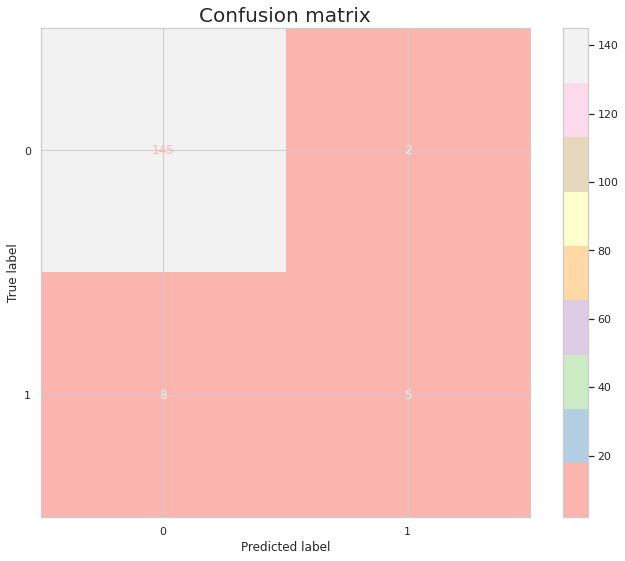

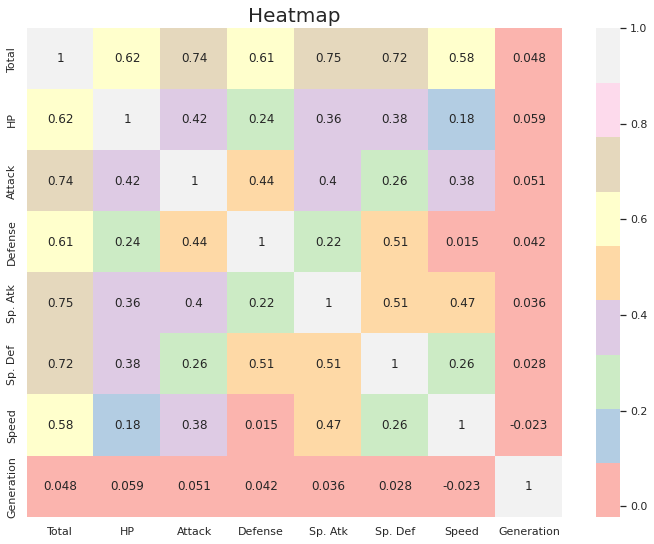

In [91]:
logistRegr_metrics(X_train, X_test, y_train, y_test, y_pred)

Metrics from before for test:
* Precision: 0.5555555555555556
* Recall: 0.38461538461538464
* Accuracy: 0.925
* F1: 0.4545454545454546

Now:
* Precision: 0.7142857142857143
* Recall: 0.38461538461538464
* Accuracy: 0.9375
* F1: 0.5

The model did improve. We now have less false positives.

### Try removing variables that correlate

Here, see that `Total` correlates a lot of with the variables, which is, well, obvious because it's the sum of them. Let's try removing it as well.

Removing total!

##### 6. Train-test-split

In [92]:
X = pokemon.drop(columns=['Name', 'Type 1', 'Type 2', 'Legendary', 'Total'])
y = pokemon['Legendary'].values

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

##### 7-10. 

Train Precision: 0.7714285714285715
Train Recall: 0.5192307692307693
Train Accuracy: 0.9484375
Train F1: 0.6206896551724139
Test Precision: 0.7142857142857143
Test Recall: 0.38461538461538464
Test Accuracy: 0.9375
Test F1: 0.5


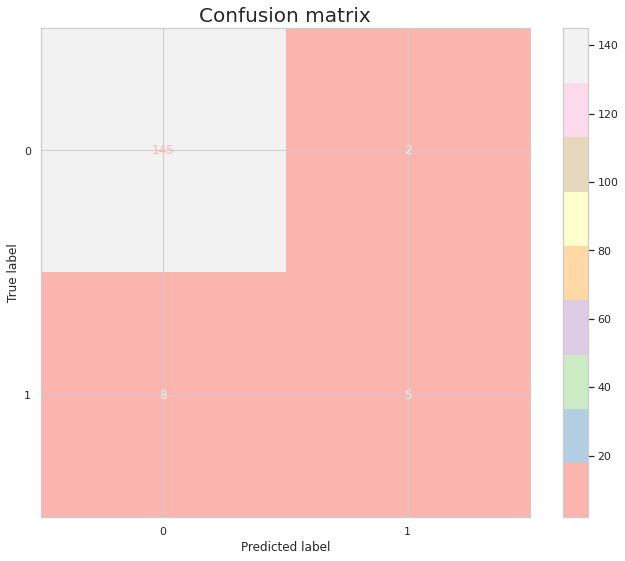

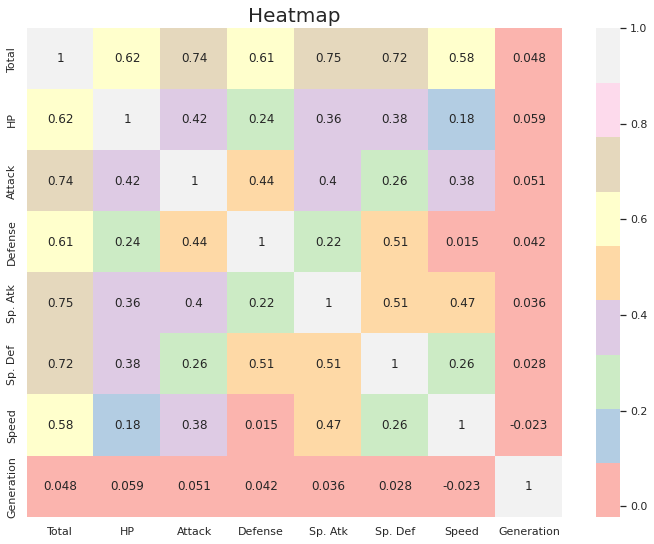

In [94]:
logistRegr_metrics(X_train, X_test, y_train, y_test, y_pred)

The metrics **stayed the same**. Meaning, `Total` did not contribute anyway.

### Removing `Generation`

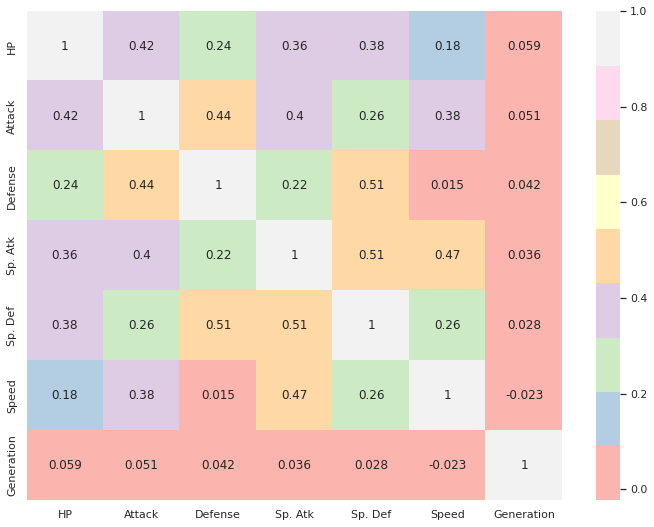

In [95]:
# Correlation matrix
corr = X.corr()

# Plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
           cmap='Pastel1', annot=True);

`Generation` might be unnecessary as well, according to the inital EDA there are a couple of legendary dragons in each `Generation`.

##### 6. Train-test-split

In [96]:
X = pokemon.drop(columns=['Name', 'Type 1', 'Type 2', 'Total', 'Generation', 'Legendary'])
y = pokemon['Legendary'].values

In [97]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

##### 7-10.

Train Precision: 0.6944444444444444
Train Recall: 0.4807692307692308
Train Accuracy: 0.940625
Train F1: 0.5681818181818181
Test Precision: 0.7142857142857143
Test Recall: 0.38461538461538464
Test Accuracy: 0.9375
Test F1: 0.5


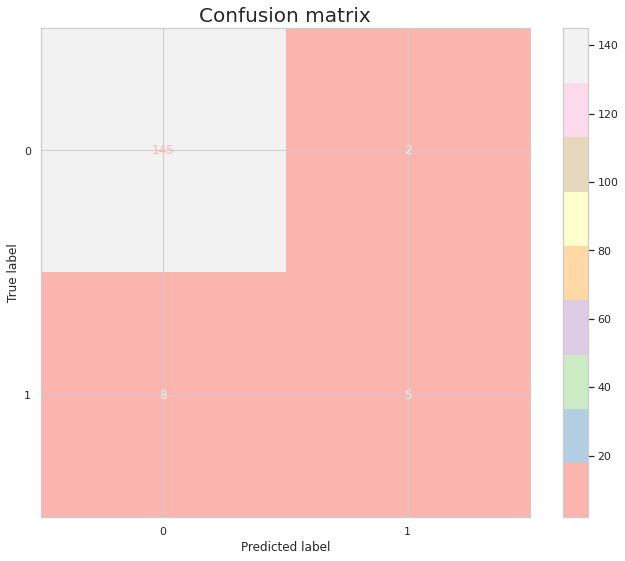

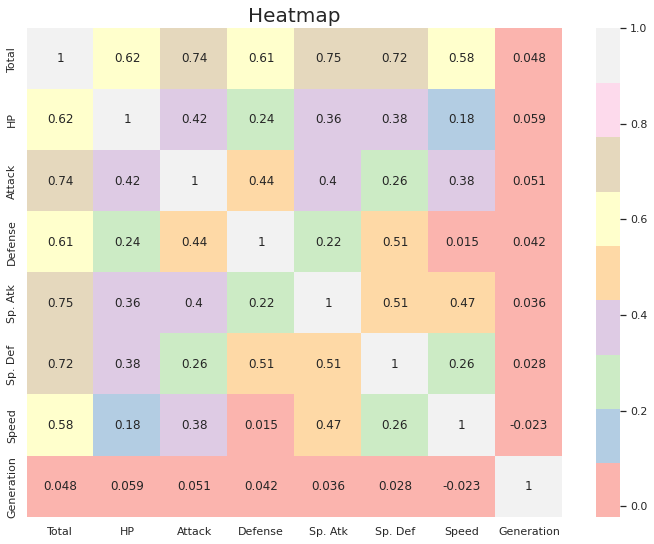

In [98]:
logistRegr_metrics(X_train, X_test, y_train, y_test, y_pred)

The metrics **stayed the same**. Meaning, `Generation` did not contribute anyway.

Let's take a look at the correlation matrix between all of the variables and y:

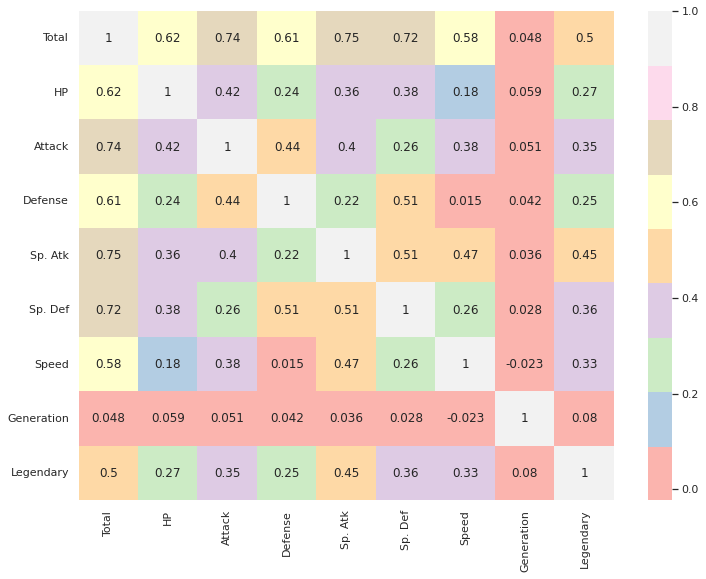

In [99]:
# Correlation matrix
corr = pokemon.corr()

# Plot the heatmap
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
           cmap='Pastel1', annot=True);

As we can see, Total highly correlates with Legendary, let's try building a model only this parameter.

##### 6. Train-test-split

In [100]:
X = pokemon['Total'].values
y = pokemon['Legendary'].values

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=SEED, stratify=y)

##### 7-10

Train Precision: 0.7741935483870968
Train Recall: 0.46153846153846156
Train Accuracy: 0.9453125
Train F1: 0.5783132530120482
Test Precision: 0.4
Test Recall: 0.3076923076923077
Test Accuracy: 0.90625
Test F1: 0.34782608695652173


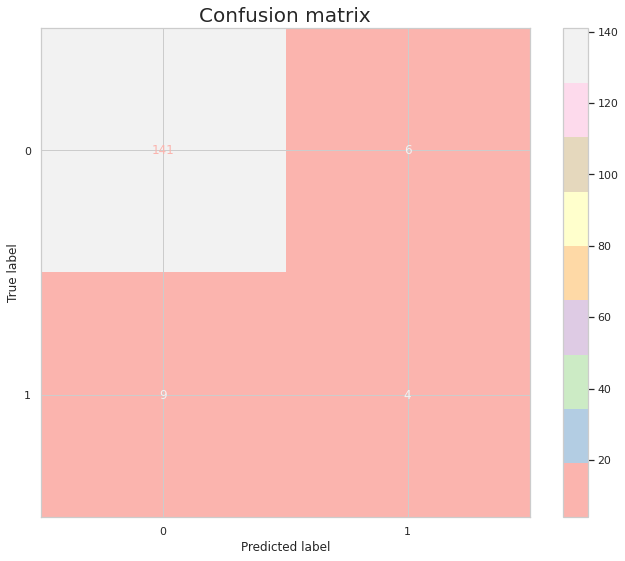

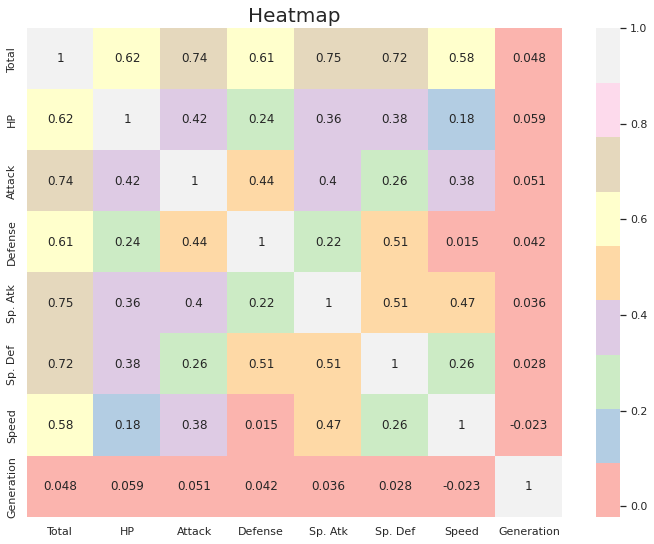

In [102]:
logistRegr_metrics(X_train.reshape(-1, 1), X_test.reshape(-1, 1), y_train, y_test, y_pred)

As we can see, you can get a fairly good model by just using one variable `Total` as well.

<font color="#4B0082">Очень здорово, единственное, что я бы лучше сделал себе функцию, чтобы много раз код для обучения, метрик и всего остального не писать.</font>

<font color="#4B0082">(6.5/5)</font>

### Задание 4. Расскажите о вашей любимой музыкальной группе (исполнителе) (0.5 балла)

Расскажите, как вы познакомились с этой группой и скиньте несколько наиболее любимых треков)

Boards of Canada:
https://www.youtube.com/watch?v=yT0gRc2c2wQ

Don't really remember how I came across the group, most probably through some youtube/spotify suggestions a couple of years ago. I even have a pullover!

<font color="#4B0082">А ты мне их кидала до этого?...</font>

<font color="#4B0082">Про меня ты знаешь, но пусть еще раз будет</font>

* [Первая, которую я узнал](https://open.spotify.com/track/3hpDQ0v0sdK4ApeGhuM7Ol?si=8f199298b171446b)
* [Концертный хит](https://open.spotify.com/track/1QLO9t2nTzNSbK2ZK1m4k0?si=c77e7c5e5f724570)
* [Это мертвый проект прошлого, и его нет нигде кроме вк и ютуба](https://www.youtube.com/watch?v=u6gQLF8pkDw&t=931s)



## Therapy time

Напишите здесь ваши впечатления о задании: было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз. 

**Ваши мысли:**

I feel like sometimes there was a little bit too much code from you. Maybe somewhere in between last and this exercise would be optimal. Clarifications in the text as well as formulas really help out.

<font color="#4B0082">Спасибо! Да пытаюсь потихоньку найти баланс между вашим кодом и моим)</font>

<font color="#4B0082">Итог: 21.5</font>